In [1]:
!pip install kagglehub==0.3.3


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import kagglehub
import os
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import itertools

/Users/lillianho/CSE_151A_Project/cse151a-trash/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download latest version of kaggle dataset
path = kagglehub.dataset_download("alistairking/recyclable-and-household-waste-classification")

print("Path to dataset files:", path)

Path to dataset files: /Users/lillianho/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1


In [8]:
# Get image paths and create lists to populate later
class_path = path + '/images' + '/images'
classes = os.listdir(class_path)
image_paths = []
labels = [] # Trash category associated with each image
d_r = [] # default (studio/standard) vs real world img

print(classes)

['disposable_plastic_cutlery', 'food_waste', 'office_paper', 'glass_food_jars', 'aluminum_soda_cans', 'magazines', 'clothing', 'plastic_shopping_bags', 'plastic_soda_bottles', 'styrofoam_food_containers', 'aerosol_cans', 'aluminum_food_cans', 'newspaper', 'eggshells', 'glass_cosmetic_containers', 'paper_cups', 'plastic_water_bottles', 'coffee_grounds', 'steel_food_cans', 'plastic_cup_lids', 'cardboard_packaging', 'cardboard_boxes', 'plastic_straws', 'styrofoam_cups', 'glass_beverage_bottles', 'shoes', 'plastic_trash_bags', 'tea_bags', 'plastic_food_containers', 'plastic_detergent_bottles']


In [9]:
# Access image folders and populate lists with needed data
for i, label in enumerate(classes):
    class_dir = os.path.join(class_path, label)
    for subfolder in ['default', 'real_world']:
        subfolder_dir = os.path.join(class_dir, subfolder)
        image_names = os.listdir(subfolder_dir)
        
        for image_name in image_names:
            d_r.append(subfolder)
            image_paths.append(os.path.join(subfolder_dir, image_name))
            labels.append(label)

In [10]:
# Get image sizes of every image and populate list
image_sizes = []
for image_path in image_paths:
    im = Image.open(image_path)
    image_sizes.append(im.size)

In [ ]:
# Create a dataframe with image paths, labels, sizes, and categorization
columnDict = {'image_path': image_paths, 'label': labels, 'image_size': image_sizes, 'default_vs_real_world': d_r}
df = pd.DataFrame(columnDict)

print(df.head())

                                          image_path  \
0  /Users/lillianho/.cache/kagglehub/datasets/ali...   
1  /Users/lillianho/.cache/kagglehub/datasets/ali...   
2  /Users/lillianho/.cache/kagglehub/datasets/ali...   
3  /Users/lillianho/.cache/kagglehub/datasets/ali...   
4  /Users/lillianho/.cache/kagglehub/datasets/ali...   

                        label  image_size default_vs_real_world  
0  disposable_plastic_cutlery  (256, 256)               default  
1  disposable_plastic_cutlery  (256, 256)               default  
2  disposable_plastic_cutlery  (256, 256)               default  
3  disposable_plastic_cutlery  (256, 256)               default  
4  disposable_plastic_cutlery  (256, 256)               default  


In [16]:
clean_df = df.copy()
clean_df.label.unique()
cat_dic = {
    'landfill' : ['clothing', 'disposable_plastic_cutlery', 'plastic_shopping_bags', 'plastic_trash_bags',\
                  'shoes', 'styrofoam_cups', 'styrofoam_food_containers', 'paper_cups', 'plastic_straws', 'plastic_cup_lids'],
    'recyclable' : ['aerosol_cans','aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'glass_beverage_bottles',\
                    'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'plastic_detergent_bottles',\
                    'plastic_food_containers','plastic_soda_bottles', 'plastic_water_bottles', 'steel_food_cans'],
    'compost' : ['coffee_grounds', 'eggshells', 'food_waste', 'tea_bags']
}

# Create a reverse lookup dictionary to map items to categories
item_to_category = {item: category for category, items in cat_dic.items() for item in items}

# Map the labels to respective categories using lookup dictionary
clean_df['category'] = df['label'].map(item_to_category)
clean_df.head()

,image_path,label,image_size,default_vs_real_world,category
0,/Users/lillianho/.cache/kagglehub/datasets/ali...,disposable_plastic_cutlery,"(256, 256)",default,landfill
1,/Users/lillianho/.cache/kagglehub/datasets/ali...,disposable_plastic_cutlery,"(256, 256)",default,landfill
2,/Users/lillianho/.cache/kagglehub/datasets/ali...,disposable_plastic_cutlery,"(256, 256)",default,landfill
3,/Users/lillianho/.cache/kagglehub/datasets/ali...,disposable_plastic_cutlery,"(256, 256)",default,landfill
4,/Users/lillianho/.cache/kagglehub/datasets/ali...,disposable_plastic_cutlery,"(256, 256)",default,landfill


In [17]:
X = clean_df['image_path']
y = clean_df['category'] 

In [18]:
# 60/20/20 split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=True)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)


In [19]:
# Finding the min and max pixel value in the training data
min_val = float('inf')
max_val = float('-inf')

for image_path in X_train:  
    image = Image.open(image_path)
    image_array = np.array(image)

    image_min = image_array.min()
    image_max = image_array.max()

    min_val = min(min_val, image_min)
    max_val = max(max_val, image_max)

print("Min Pixel Value:", min_val)
print("Max Pixel Value:", max_val)

Min Pixel Value: 0
Max Pixel Value: 255


In [20]:
def normalize_image(image_path):
    image = Image.open(image_path)
    image_array = np.array(image)

    # normalize with min-max scaling
    normalized_image = (image_array - min_val) / (max_val - min_val)
    return normalized_image

X_train_normalized = X_train.apply(normalize_image)
X_valid_normalized = X_valid.apply(normalize_image)
X_test_normalized = X_test.apply(normalize_image)

In [21]:
# Flatten each image to create 1D feature vectors
# X_train_flat = np.array([image.flatten() for image in X_train_normalized])
# X_test_flat = np.array([image.flatten() for image in X_test_normalized])

image_size = 256 * 256 * 3
X_train_flat = np.memmap('X_train_flat.dat', dtype='float32', mode='w+', shape=(len(X_train_normalized), image_size))
X_valid_flat = np.memmap('X_valid_flat.dat', dtype='float32', mode='w+', shape=(len(X_valid_normalized), image_size))
X_test_flat = np.memmap('X_test_flat.dat', dtype='float32', mode='w+', shape=(len(X_test_normalized), image_size))

# Fill in the memory-mapped arrays
for i, image in enumerate(X_train_normalized):
    X_train_flat[i] = image.flatten()
    
for i, image in enumerate(X_valid_normalized):
    X_valid_flat[i] = image.flatten()

for i, image in enumerate(X_test_normalized):
    X_test_flat[i] = image.flatten()

# Random Forest Classification

Basic Random Forest classifier with the default hyperparameter values: 
* `n_estimators` = 100
* `max_depth` = None
* `min_samples_split` = 2

In [156]:
rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(X_train_flat, y_train)

RandomForestClassifier(random_state=42)

In [157]:
y_pred = rf_model.predict(X_test_flat)

In [158]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy}")

Accuracy on test set: 0.7756666666666666


In [159]:
y_train_pred = rf_model.predict(X_train_flat)

train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy: ", train_accuracy)

Training Accuracy:  0.9996666666666667


In [160]:
y_valid_pred = rf_model.predict(X_valid_flat)

valid_accuracy = accuracy_score(y_valid, y_valid_pred)
print("Validation Accuracy: ", valid_accuracy)

Validation Accuracy:  0.7983333333333333


Ground Truth and Predictions For Training Set
Ground Truth: recyclable
Prediction: recyclable
Ground Truth: recyclable
Prediction: recyclable
Ground Truth: landfill
Prediction: landfill
Ground Truth: recyclable
Prediction: recyclable
Ground Truth: recyclable
Prediction: recyclable

Ground Truth and Predictions For Validation Set
Ground Truth: compost
Prediction: compost
Ground Truth: recyclable
Prediction: recyclable
Ground Truth: recyclable
Prediction: recyclable
Ground Truth: compost
Prediction: compost
Ground Truth: landfill
Prediction: landfill

Ground Truth and Predictions For Testing Set
Ground Truth: landfill
Prediction: recyclable
Ground Truth: landfill
Prediction: recyclable
Ground Truth: landfill
Prediction: landfill
Ground Truth: landfill
Prediction: landfill
Ground Truth: recyclable
Prediction: recyclable


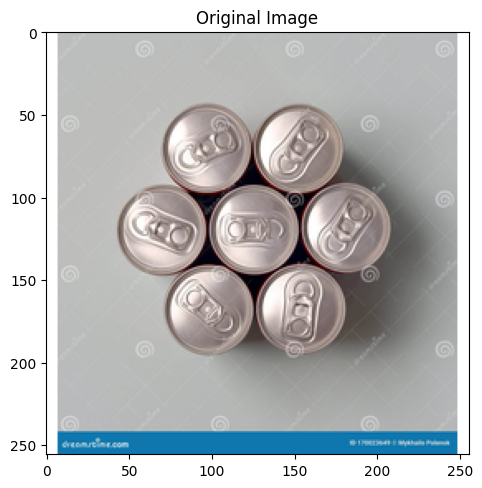

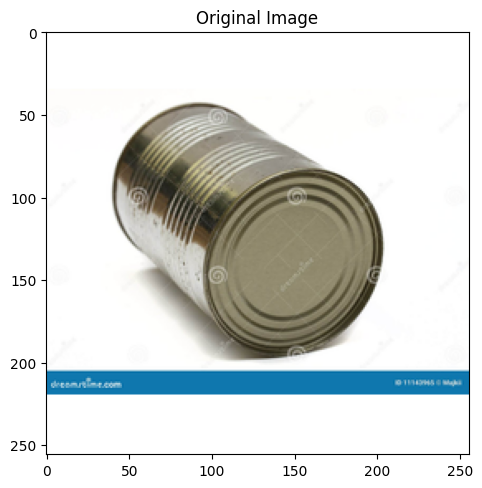

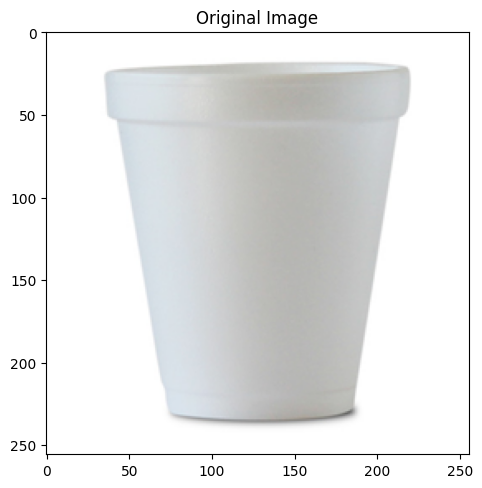

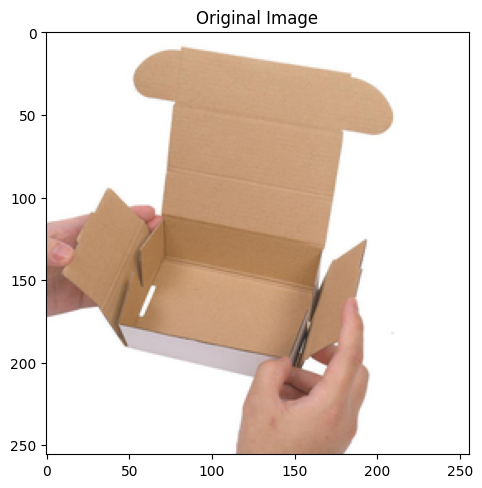

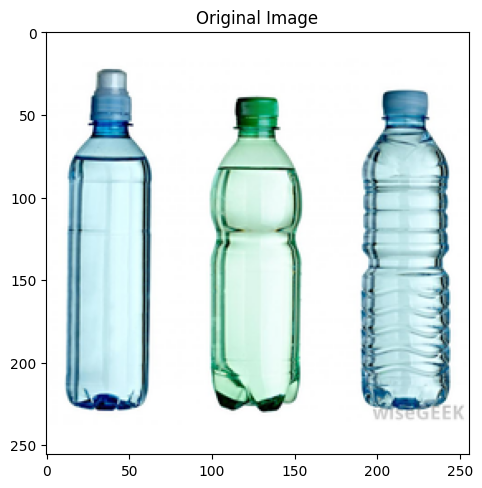

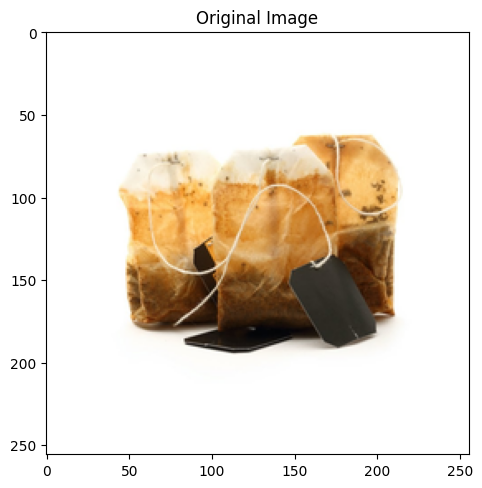

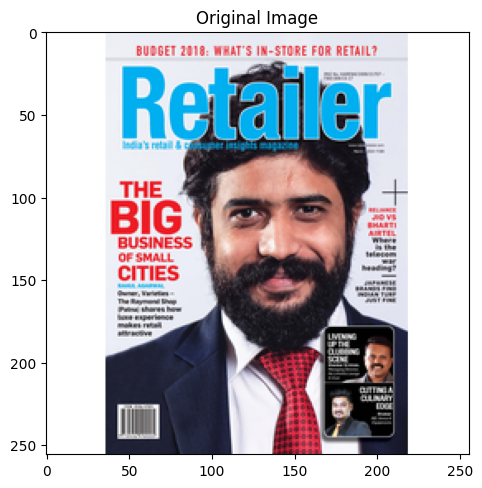

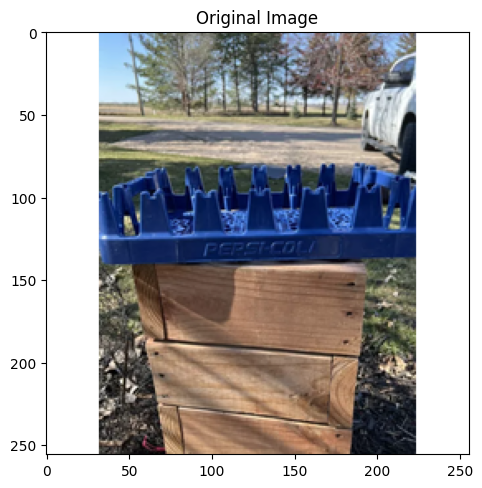

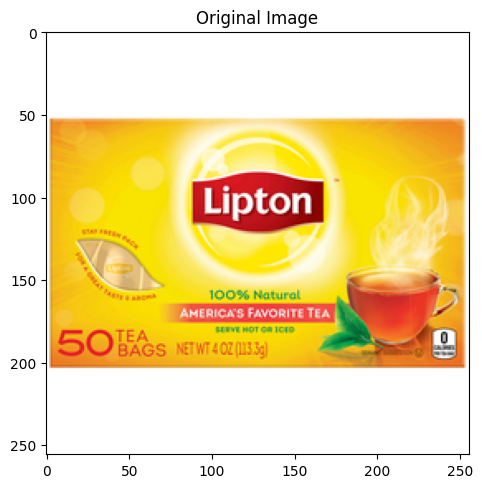

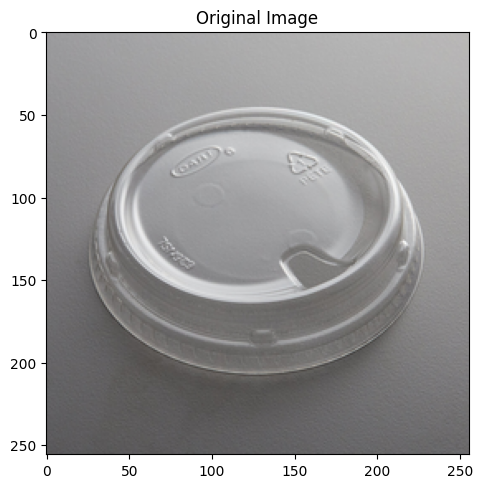

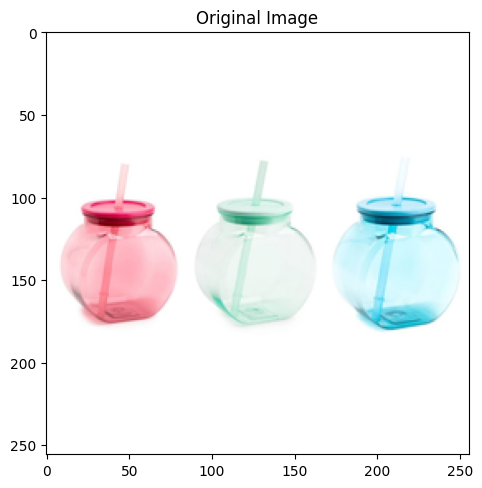

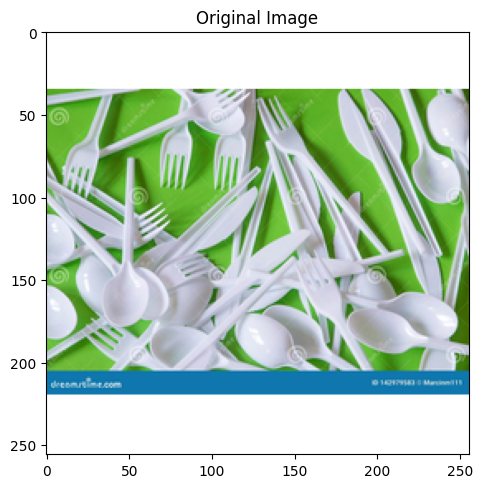

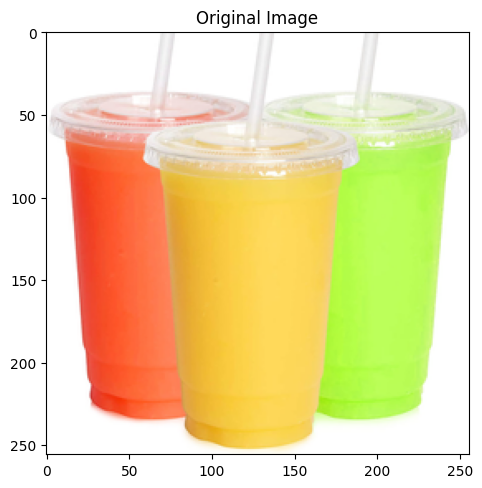

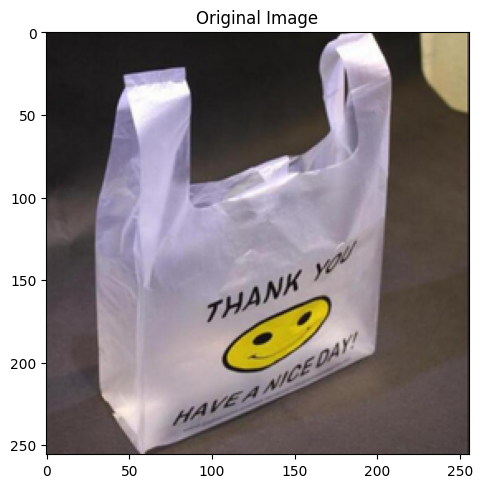

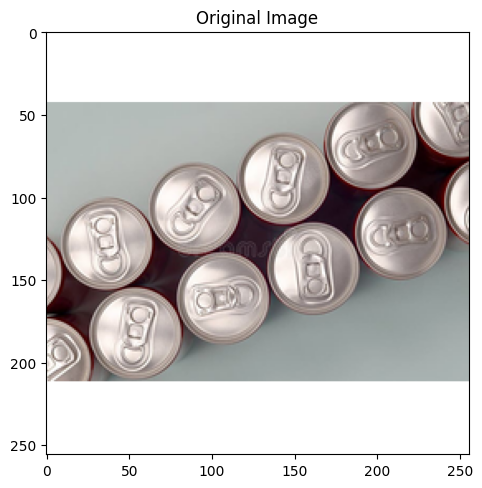

In [161]:
# example ground truth and predictions for train, validation and test
print("Ground Truth and Predictions For Training Set")
length = len(y_train)
for i in range(0, length, int(length/5)):
  sample_image_path = X_train.iloc[i] 

  original_image = Image.open(sample_image_path)
  original_image = np.array(original_image)
  plt.figure(figsize=(12, 6))

  # Original Image
  plt.subplot(1, 2, 1)
  plt.imshow(original_image)
  plt.title("Original Image")
  print("Ground Truth:", y_train.iloc[i])
  print("Prediction:", y_train_pred[i])
  
print("\nGround Truth and Predictions For Validation Set")
length = len(y_valid)
for i in range(0, length, int(length/5)):
  sample_image_path = X_valid.iloc[i] 

  original_image = Image.open(sample_image_path)
  original_image = np.array(original_image)
  plt.figure(figsize=(12, 6))

  # Original Image
  plt.subplot(1, 2, 1)
  plt.imshow(original_image)
  plt.title("Original Image")
  print("Ground Truth:", y_valid.iloc[i])
  print("Prediction:", y_valid_pred[i])

print("\nGround Truth and Predictions For Testing Set")
length = len(y_pred)
for i in range(0, length, int(length/5)):
  sample_image_path = X_test.iloc[i] 

  original_image = Image.open(sample_image_path)
  original_image = np.array(original_image)
  plt.figure(figsize=(12, 6))

  # Original Image
  plt.subplot(1, 2, 1)
  plt.imshow(original_image)
  plt.title("Original Image")
  print("Ground Truth:", y_test.iloc[i])
  print("Prediction:", y_pred[i])

## Hyperparameter Tuning for Random Forest

We will be tuning the following three hyperparameters to address the overfitting observed with the original model:
* `n_estimators`: Number of trees in the forest
* `max_depth`: Maximum depth of each tree
* `min_samples_split`: Minimum number of samples required to split an internal node

The goal is to identify the combination of these parameters that achieves the best validation accuracy while avoiding overfitting or underfitting. The results will be stored in a DataFrame for further analysis:

In [164]:
def tune_rf_hyperparameters(X_train_flat, y_train, X_valid_flat, y_valid):
    param_grid = {
        'n_estimators': [50, 60, 70, 80, 90, 100],
        'max_depth': [5, 7, 10, 12, 15],
        'min_samples_split': [2, 3, 5, 7, 10],
    }

    best_val_acc = 0
    best_params = None
    results = []

    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for min_samples_split in param_grid['min_samples_split']:
                
                rf_model = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    n_jobs=-1,
                    random_state=42
                )

                rf_model.fit(X_train_flat, y_train)

                train_acc = accuracy_score(y_train, rf_model.predict(X_train_flat))
                valid_acc = accuracy_score(y_valid, rf_model.predict(X_valid_flat))

                print(f"Params: n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split} | "
                    f"Train Acc: {train_acc:.3f}, Valid Acc: {valid_acc:.3f}")

                # Store results
                results.append({
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'train_acc': train_acc,
                    'valid_acc': valid_acc,
                })

                if valid_acc > best_val_acc:
                    best_val_acc = valid_acc
                    best_params = {
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                    }

    print(f"\nBest Parameters: {best_params}, Best Validation Accuracy: {best_val_acc}")

    df = pd.DataFrame(results)
    return df, best_params


In [165]:
res_df, best_params = tune_rf_hyperparameters(X_train_flat, y_train, X_valid_flat, y_valid)

Params: n_estimators=50, max_depth=5, min_samples_split=2 | Train Acc: 0.636, Valid Acc: 0.627
Params: n_estimators=50, max_depth=5, min_samples_split=3 | Train Acc: 0.636, Valid Acc: 0.627
Params: n_estimators=50, max_depth=5, min_samples_split=5 | Train Acc: 0.635, Valid Acc: 0.625
Params: n_estimators=50, max_depth=5, min_samples_split=7 | Train Acc: 0.636, Valid Acc: 0.626
Params: n_estimators=50, max_depth=5, min_samples_split=10 | Train Acc: 0.637, Valid Acc: 0.628
Params: n_estimators=50, max_depth=7, min_samples_split=2 | Train Acc: 0.756, Valid Acc: 0.680
Params: n_estimators=50, max_depth=7, min_samples_split=3 | Train Acc: 0.757, Valid Acc: 0.684
Params: n_estimators=50, max_depth=7, min_samples_split=5 | Train Acc: 0.759, Valid Acc: 0.687
Params: n_estimators=50, max_depth=7, min_samples_split=7 | Train Acc: 0.754, Valid Acc: 0.684
Params: n_estimators=50, max_depth=7, min_samples_split=10 | Train Acc: 0.751, Valid Acc: 0.689
Params: n_estimators=50, max_depth=10, min_sampl

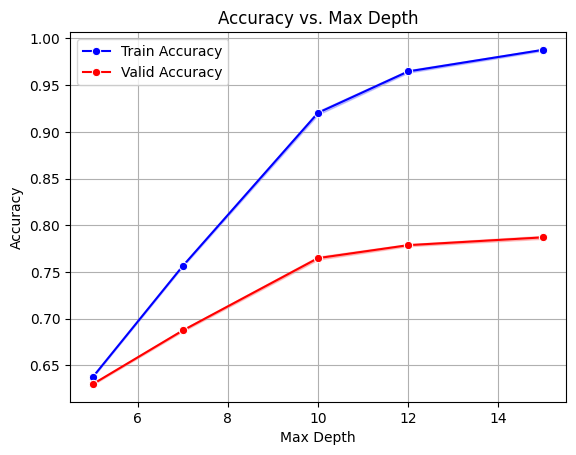

In [168]:
sns.lineplot(data=res_df, x='max_depth', y='train_acc', label='Train Accuracy', marker='o', linestyle='-', color='b')
sns.lineplot(data=res_df, x='max_depth', y='valid_acc', label='Valid Accuracy', marker='o', linestyle='-', color='r')
plt.title('Accuracy vs. Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

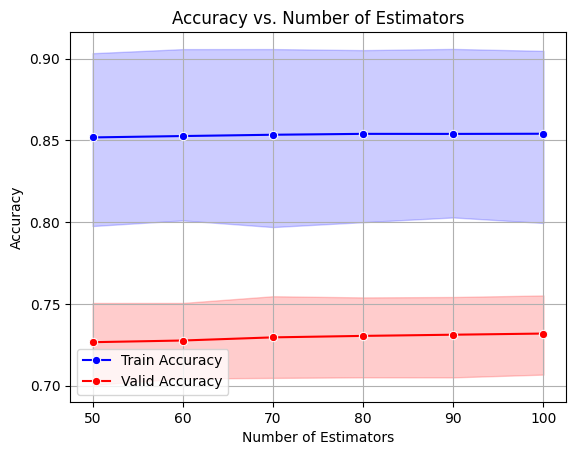

In [169]:
sns.lineplot(data=res_df, x='n_estimators', y='train_acc', label='Train Accuracy', marker='o', linestyle='-', color='b')
sns.lineplot(data=res_df, x='n_estimators', y='valid_acc', label='Valid Accuracy', marker='o', linestyle='-', color='r')

plt.title('Accuracy vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

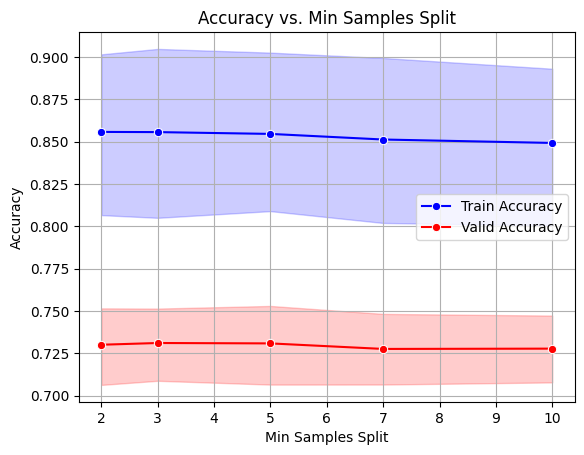

In [170]:
sns.lineplot(data=res_df, x='min_samples_split', y='train_acc', label='Train Accuracy', marker='o', linestyle='-', color='b')
sns.lineplot(data=res_df, x='min_samples_split', y='valid_acc', label='Valid Accuracy', marker='o', linestyle='-', color='r')

plt.title('Accuracy vs. Min Samples Split')
plt.xlabel('Min Samples Split')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [171]:
res_df['train_valid_diff'] = abs(res_df['train_acc'] - res_df['valid_acc'])
threshold = 0.1

# Filter models that have low differences between training and validation accuracy
filtered_df = res_df[(res_df['train_valid_diff'] <= threshold)]

# Sort by validation accuracy
sorted_filtered_df = filtered_df.sort_values(by='valid_acc', ascending=False)

sorted_filtered_df

,n_estimators,max_depth,min_samples_split,train_acc,valid_acc,train_valid_diff
107,90,7,5,0.758778,0.692333,0.066444
132,100,7,5,0.759111,0.692000,0.067111
32,60,7,5,0.755556,0.691000,0.064556
106,90,7,3,0.757889,0.691000,0.066889
134,100,7,10,0.752889,0.691000,0.061889
82,80,7,5,0.759444,0.689333,0.070111
109,90,7,10,0.754556,0.689333,0.065222
131,100,7,3,0.758889,0.689000,0.069889
34,60,7,10,0.754000,0.688667,0.065333
9,50,7,10,0.751111,0.688667,0.062444


In [172]:
# Using parameters that achieved the highest test accuracy from the previous cell
improved_rf_model = RandomForestClassifier(n_estimators=90, max_depth=7, min_samples_split=5, n_jobs=-1)

improved_rf_model.fit(X_train_flat, y_train)

RandomForestClassifier(max_depth=7, min_samples_split=5, n_estimators=90,
                       n_jobs=-1)

In [173]:
improved_y_test_pred = improved_rf_model.predict(X_test_flat)

test_accuracy = accuracy_score(y_test, improved_y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.6596666666666666


In [174]:
improved_y_valid_pred = improved_rf_model.predict(X_valid_flat)

valid_accuracy = accuracy_score(y_valid, improved_y_valid_pred)
print(f"Valid Accuracy: {valid_accuracy}")

Valid Accuracy: 0.686


In [175]:
improved_y_train_pred = improved_rf_model.predict(X_train_flat)

train_accuracy = accuracy_score(y_train, improved_y_train_pred)
print(f"Training Accuracy: {train_accuracy}")

Training Accuracy: 0.7524444444444445


In [177]:
rf_cm= confusion_matrix(y_test, improved_y_test_pred)

In [178]:
# CODE COPIED FROM SCI-KIT LEARN
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 127   25  243]
 [  13  378  681]
 [  12   47 1474]]


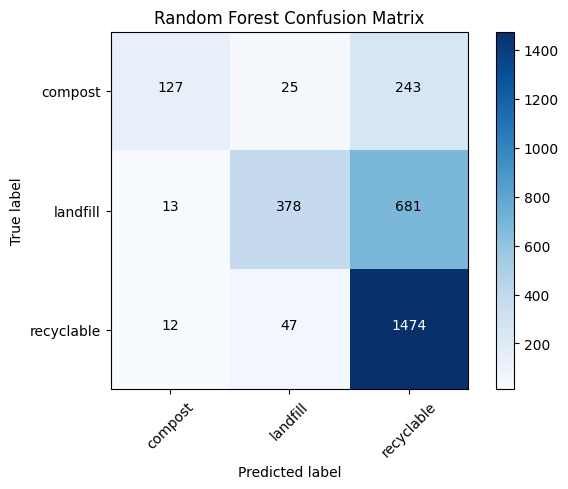

In [179]:
cm_plot_labels = ['compost', 'landfill', 'recyclable']
plot_confusion_matrix(cm=rf_cm, classes=cm_plot_labels, title='Random Forest Confusion Matrix')


In [180]:
accuracy = accuracy_score(y_test, improved_y_test_pred)
precision = precision_score(y_test, improved_y_test_pred, average='macro') 
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.6596666666666666
Precision: 0.7634017382906809
Recall: 0.7227903046304968
F1 Score: 0.7520317285770562


### Exploring HOG Features

In [181]:
def extract_hog_features(images):
    hog_features = []
    for image in images:
        image_gray = rgb2gray(image)
        
        features = hog(
            image_gray,
            orientations=9,        
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=False  
        )
        hog_features.append(features)
    
    return np.array(hog_features)

In [182]:
X_train_hog = extract_hog_features(X_train_normalized)
X_valid_hog= extract_hog_features(X_valid_normalized)
X_test_hog = extract_hog_features(X_test_normalized)

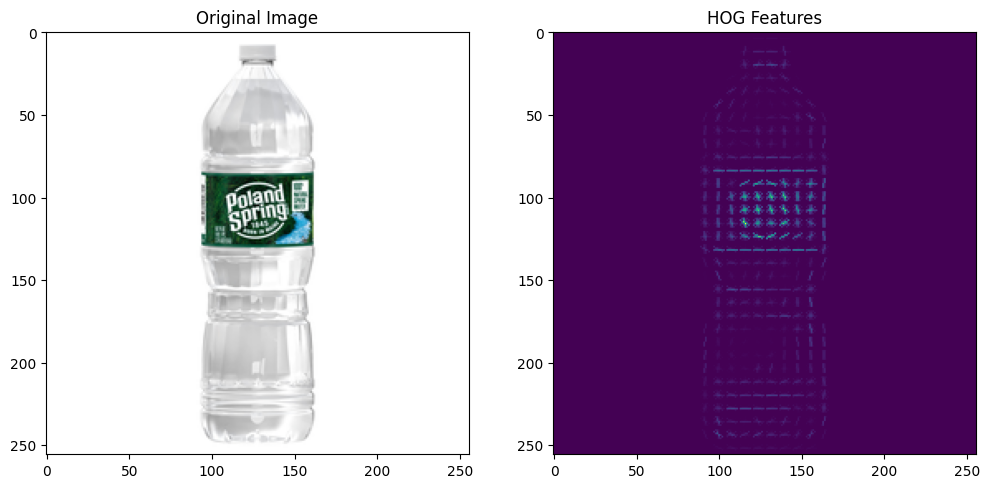

In [183]:
sample_image_path = X_train.iloc[1] 
original_image = Image.open(sample_image_path)
original_image = np.array(original_image)

sample_image_gray = rgb2gray(original_image)
        
features, hog_image = hog(
    sample_image_gray,
    orientations=9,        
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=True  
)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(hog_image)
plt.title("HOG Features")

plt.show()

In [185]:
hog_rf_model = RandomForestClassifier(random_state=42)

hog_rf_model.fit(X_train_hog, y_train)

RandomForestClassifier(random_state=42)

In [186]:
y_test_pred = hog_rf_model.predict(X_test_hog)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.7626666666666667


In [187]:
y_valid_pred = hog_rf_model.predict(X_valid_hog)

valid_accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Valid Accuracy: {valid_accuracy}")

Valid Accuracy: 0.7696666666666667


In [188]:
y_train_pred = hog_rf_model.predict(X_train_hog)

train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy: ", train_accuracy)

Training Accuracy:  0.9996666666666667


In [190]:
# Tune hyperparameters to address overfitting
hog_res_df, best_hog_params = tune_rf_hyperparameters(X_train_hog, y_train, X_valid_hog, y_valid)

Params: n_estimators=50, max_depth=5, min_samples_split=2 | Train Acc: 0.603, Valid Acc: 0.583
Params: n_estimators=50, max_depth=5, min_samples_split=3 | Train Acc: 0.604, Valid Acc: 0.584
Params: n_estimators=50, max_depth=5, min_samples_split=5 | Train Acc: 0.604, Valid Acc: 0.585
Params: n_estimators=50, max_depth=5, min_samples_split=7 | Train Acc: 0.603, Valid Acc: 0.585
Params: n_estimators=50, max_depth=5, min_samples_split=10 | Train Acc: 0.602, Valid Acc: 0.584
Params: n_estimators=50, max_depth=7, min_samples_split=2 | Train Acc: 0.729, Valid Acc: 0.640
Params: n_estimators=50, max_depth=7, min_samples_split=3 | Train Acc: 0.729, Valid Acc: 0.642
Params: n_estimators=50, max_depth=7, min_samples_split=5 | Train Acc: 0.725, Valid Acc: 0.640
Params: n_estimators=50, max_depth=7, min_samples_split=7 | Train Acc: 0.728, Valid Acc: 0.642
Params: n_estimators=50, max_depth=7, min_samples_split=10 | Train Acc: 0.726, Valid Acc: 0.639
Params: n_estimators=50, max_depth=10, min_sampl

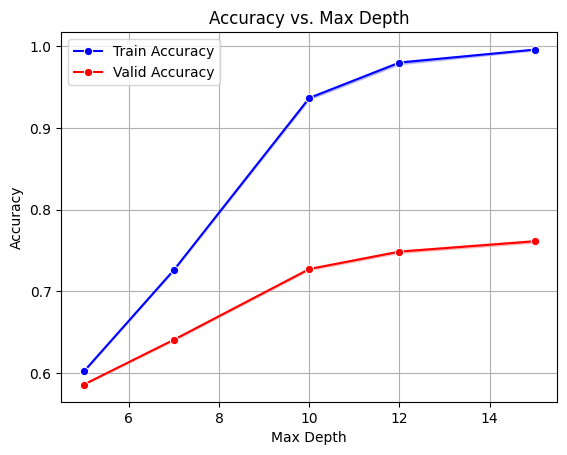

In [194]:
sns.lineplot(data=hog_res_df, x='max_depth', y='train_acc', label='Train Accuracy', marker='o', linestyle='-', color='b')
sns.lineplot(data=hog_res_df, x='max_depth', y='valid_acc', label='Valid Accuracy', marker='o', linestyle='-', color='r')

plt.title('Accuracy vs. Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

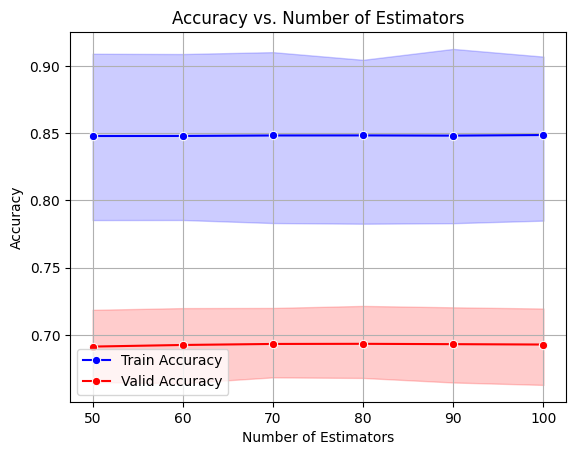

In [196]:
sns.lineplot(data=hog_res_df, x='n_estimators', y='train_acc', label='Train Accuracy', marker='o', linestyle='-', color='b')
sns.lineplot(data=hog_res_df, x='n_estimators', y='valid_acc', label='Valid Accuracy', marker='o', linestyle='-', color='r')

plt.title('Accuracy vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

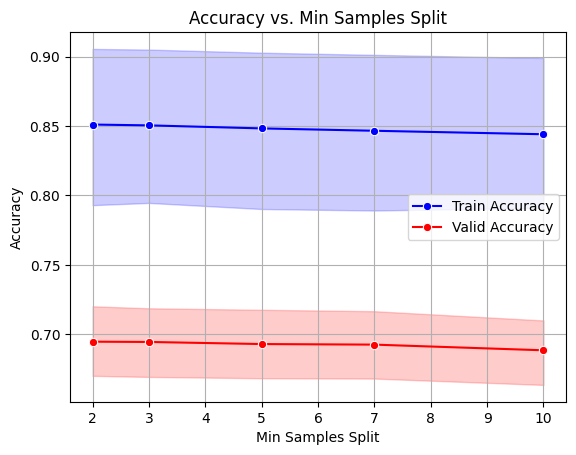

In [197]:
sns.lineplot(data=hog_res_df, x='min_samples_split', y='train_acc', label='Train Accuracy', marker='o', linestyle='-', color='b')
sns.lineplot(data=hog_res_df, x='min_samples_split', y='valid_acc', label='Valid Accuracy', marker='o', linestyle='-', color='r')

plt.title('Accuracy vs. Min Samples Split')
plt.xlabel('Min Samples Split')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [199]:
hog_res_df['train_valid_diff'] = abs(hog_res_df['train_acc'] - hog_res_df['valid_acc'])
threshold = 0.1

# Filter models that have low differences between training and validation accuracy
filtered_hog_df = hog_res_df[(hog_res_df['train_valid_diff'] <= threshold)]

# Sort by validation accuracy
sorted_filtered_hog_df = filtered_hog_df.sort_values(by='valid_acc', ascending=False)
sorted_filtered_hog_df

,n_estimators,max_depth,min_samples_split,train_acc,valid_acc,train_valid_diff
81,80,7,3,0.729111,0.645667,0.083444
57,70,7,5,0.726111,0.645333,0.080778
55,70,7,2,0.730667,0.645000,0.085667
30,60,7,2,0.729222,0.644333,0.084889
56,70,7,3,0.727889,0.644000,0.083889
31,60,7,3,0.729111,0.643667,0.085444
6,50,7,3,0.728889,0.642333,0.086556
8,50,7,7,0.727778,0.642000,0.085778
58,70,7,7,0.725889,0.641667,0.084222
80,80,7,2,0.728222,0.641333,0.086889


In [206]:
improved_hog_rf_model = RandomForestClassifier(n_estimators=80, max_depth=7, min_samples_split=3, n_jobs=-1)

improved_hog_rf_model.fit(X_train_hog, y_train)

RandomForestClassifier(max_depth=7, min_samples_split=3, n_estimators=80,
                       n_jobs=-1)

In [207]:
improved_hog_y_test_pred = improved_hog_rf_model.predict(X_test_hog)

test_accuracy = accuracy_score(y_test, improved_hog_y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.6216666666666667


In [208]:
improved_hog_y_valid_pred = improved_hog_rf_model.predict(X_valid_hog)

valid_accuracy = accuracy_score(y_valid, improved_hog_y_valid_pred)
print(f"Valid Accuracy: {valid_accuracy}")

Valid Accuracy: 0.6386666666666667


In [209]:
improved_hog_y_train_pred = improved_hog_rf_model.predict(X_train_hog)

train_accuracy = accuracy_score(y_train, improved_hog_y_train_pred)
print(f"Training Accuracy: {train_accuracy}")

Training Accuracy: 0.7285555555555555


In [210]:
rf_hog_cm= confusion_matrix(y_test, improved_hog_y_test_pred)

Confusion matrix, without normalization
[[  50   14  331]
 [   2  310  760]
 [   3   25 1505]]


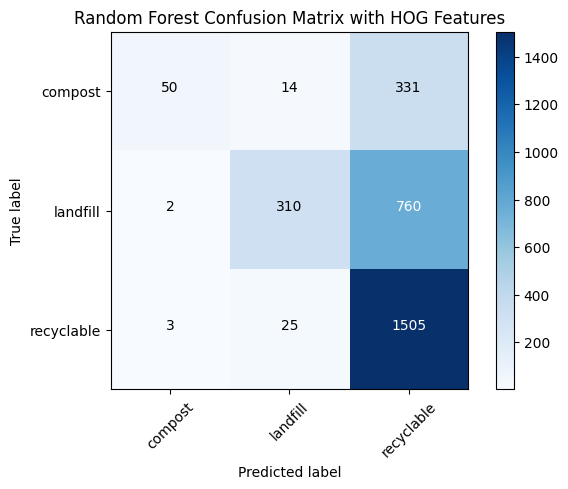

In [211]:
plot_confusion_matrix(cm=rf_hog_cm, classes=cm_plot_labels, title='Random Forest Confusion Matrix with HOG Features')